This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/extract_features.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


In [1]:
COLAB_RUNTIME = False
GITHUB_TOKEN = None

## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [2]:
%%capture
try:
    import colab
    COLAB_RUNTIME = True
    # Check CMake >= 3.21
    v_str, *_ = !cmake --version
    if 'command not found' in v_str:
        major, minor = (0, 0)
    else:
        major, minor, _ = (int(x) for x in v_str.split(' ')[-1].split('.'))
    if major < 3 or minor < 21:
        # https://cmake.org/download/
        %cd /tmp
        !wget https://github.com/Kitware/CMake/releases/download/v3.22.3/cmake-3.22.3-linux-x86_64.sh
        !sudo mkdir /opt/cmake
        !sudo sh ./cmake-3.22.3-linux-x86_64.sh --prefix=/opt/cmake \
            --skip-license
        %cd /content
        !update-alternatives --install /usr/local/bin/cmake cmake \
            /opt/cmake/bin/cmake 20 --force
except ImportError:
    pass

## AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
will be asked during the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [3]:
if COLAB_RUNTIME:
    from getpass import getpass
    if not GITHUB_TOKEN:
        GITHUB_TOKEN = getpass(
            "Personal access token\n"
            r"https://docs.github.com/en/authentication/keeping-your-account-"
            r"and-data-secure/creating-a-personal-access-token"+"\n"
            )
    %pip install git+https://$GITHUB_TOKEN@github.com/AcousticOdometry/AO
    try:
        import ao
    except ImportError:
        GITHUB_TOKEN = None
        raise
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

## Other packages


In [4]:
import ao
import math
import time
import numpy as np
import pandas as pd

from typing import Optional, Callable, List
from matplotlib import pyplot as plt
from matplotlib.image import imsave
from tqdm.notebook import tqdm
from pathlib import Path

# Validation

Here we prove that the feature extractor implemented (using a [Gammatone
Filterbank](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/gammatone/))
works as expected.


We will use the same audio file as in the [original
implementation](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/)
(A matlab C extension).


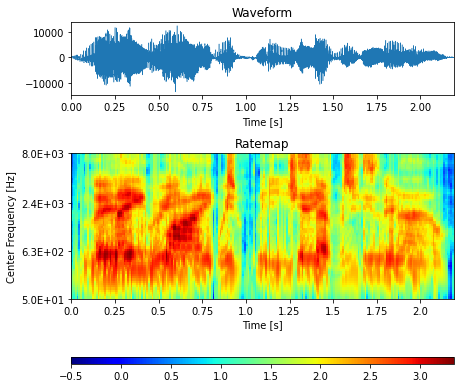

In [5]:
audio_url = (
    r"https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources"
    r"/ratemap/t29_lwwj2n_m17_lgwe7s.wav"
    )
data, sample_rate = ao.io.wave_read(audio_url)
frame_length = 10  # [ms]
frame_samples = int(
    np.ceil(frame_length / 1000 * sample_rate)
    )  # samples per frame
fig, axs = plt.subplots(
    3, 1, figsize=(6.5, 5.5), gridspec_kw={'height_ratios': [0.5, 1, 0.05]}
    )
# Signal
ao.plot.signal(data, sample_rate, ax=axs[0])
axs[0].set_title('Waveform')
# Gammatonegram
frame_length = 10  # [ms]
frame_samples = math.ceil(frame_length / 1000 * sample_rate)
plot, _ = ao.plot.gammatonegram(
    data,
    sample_rate,
    frame_samples,
    num_features=64,
    low_Hz=50,
    high_Hz=8000,
    pcolormesh_kwargs={
        'cmap': 'jet',
        'vmin': -0.5
        },
    ax=axs[1]
    )
axs[1].set_title('Ratemap')
fig.colorbar(plot, cax=axs[2], orientation="horizontal")
fig.tight_layout()

One can see that our implementation corresponds with the example found in the
original implementation.

![Ratemap](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/ratemap.png)


# Primitive Experiment

Looks for `PRIMITIVE_EXPERIMENT` in the environment variables


In [6]:
if COLAB_RUNTIME:
    # TODO Mount drive and find VAO_Primitive-Experiment
    # TODO Otherwise prompt to add shortcut to drive from link
    # https://drive.google.com/drive/folders/1I6dq8gJpsrD3C14-WQKD4IFOnkiVuvFX
    raise NotImplementedError()
else:
    DATA_FOLDER = ao.dataset.utils.get_data_folder(env='PRIMITIVE_EXPERIMENT')
data, naming = ao.dataset.utils.list_data(DATA_FOLDER)

c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:123: UserWarning: Could not parse VAO_2022-03-08_17-12-37 from VAO_2022-03-08_17-12-37, item VAO_2022-03-08_17-12-37 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))
c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:123: UserWarning: Could not parse VAO_2022-03-08_17-11-21 from VAO_2022-03-08_17-11-21, item VAO_2022-03-08_17-11-21 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))


In [7]:
def plot_primitive_experiment(audio_file, ax=None):
    data, sample_rate = ao.io.wave_read(audio_file)
    frame_length = 500  # [ms]
    frame_samples = int(
        np.ceil(frame_length / 1000 * sample_rate)
        )  # samples per frame
    return ao.plot.gammatonegram(
        data,
        sample_rate,
        frame_samples,
        num_features=64,
        low_Hz=0,
        high_Hz=22050,
        pcolormesh_kwargs={
            'cmap': 'jet',
            'vmin': -1
            },
        ax=ax
        )

IndexError: index 3 is out of bounds for axis 0 with size 3

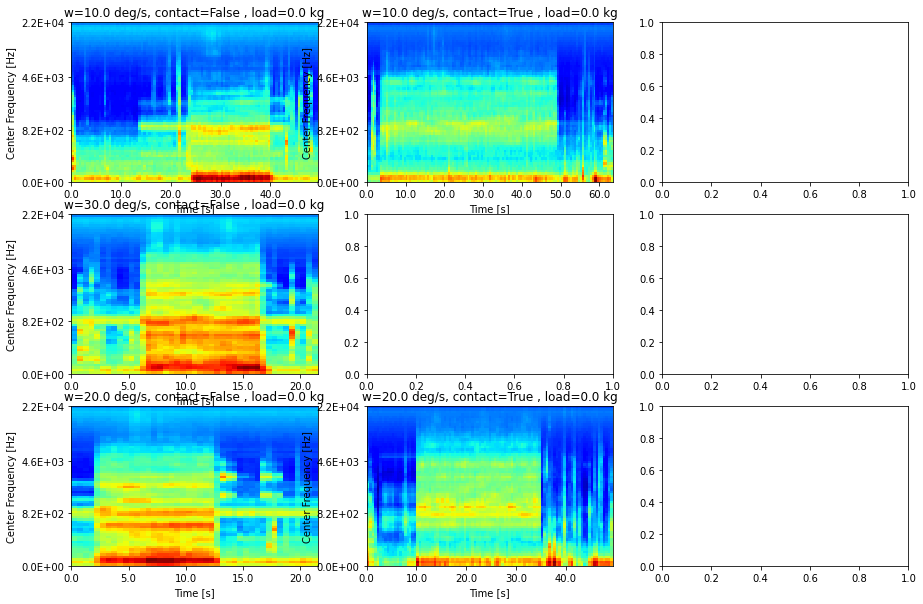

In [8]:
# w_data = {}
# for c in data.values():
#     w_data[c['w']] = w_data.get(c['w'], []) + [c]
# fig, axs = plt.subplots(
#     len(w_data), max([len(v) for v in w_data.values()]), figsize=(15, 10)
#     )
# row = -1
# last_w = None
# for folder, experiment in data.items():
#     if last_w != experiment['w']:
#         row += 1
#         col = 0
#     else:
#         col += 1
#     last_w = experiment['w']
#     plot, ax = plot_primitive_experiment(
#         folder / 'audio0.wav', ax=axs[row, col]
#         )
#     ax.set_title(
#         ', '.join(
#             f"{k}={experiment[k]} {naming[k].get('unit', '')}"
#             for k in naming.keys()
#             )
#         )
# fig.colorbar(plot, cax=axs[-1, -1])
# fig.tight_layout()

ValueError: G:\Shared drives\VAO [Andreu's Thesis]\VAO_Prototype-Experiment\recordings\w_10;load_0;contact_no\audio0crop.wav is neither a URL nor a file found in the system

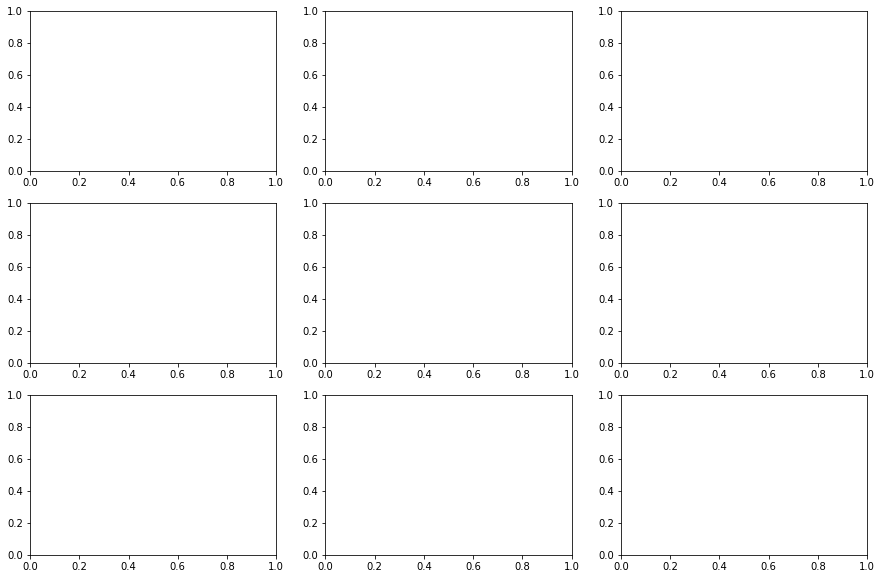

In [9]:
# w_data = {}
# for c in data.values():
#     w_data[c['w']] = w_data.get(c['w'], []) + [c]
# fig, axs = plt.subplots(
#     len(w_data), max([len(v) for v in w_data.values()]), figsize=(15, 10)
#     )
# row = -1
# last_w = None
# for folder, experiment in data.items():
#     if last_w != experiment['w']:
#         row += 1
#         col = 0
#     else:
#         col += 1
#     last_w = experiment['w']
#     plot, ax = plot_primitive_experiment(
#         folder / 'audio0crop.wav', ax=axs[row, col]
#         )
#     ax.set_title(
#         ', '.join(
#             f"{k}={experiment[k]} {naming[k].get('unit', '')}"
#             for k in naming.keys()
#             )
#         )
# fig.colorbar(plot, cax=axs[-1, -1])
# fig.tight_layout()

# WheelTestBed Experiment

In this section we will take a closer look to the Wheel Test Bed Experiment
results. We will generate an image dataset with features extracted from the
audio in order to train a classifier.

The dataset should be `WHEELTESTBED_EXPERIMENT` in the environment variables


In [ ]:
if COLAB_RUNTIME:
    # TODO Mount drive and find VAO_WheelTestBed-Experiment
    # TODO Otherwise prompt to add shortcut to drive from link
    # https://drive.google.com/drive/folders/1I6dq8gJpsrD3C14-WQKD4IFOnkiVuvFX
    raise NotImplementedError()
else:
    DATA_FOLDER = ao.dataset.utils.get_data_folder(
        env='WHEELTESTBED_EXPERIMENT'
        )
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)
print(next(iter(recordings.items())))

(WindowsPath("G:/Shared drives/VAO [Andreu's Thesis]/VAO_WheelTestBed-Experiment/recordings/w_15.00;s_nan;contact_false;load_0;duration_10;delay_3000;date_2022-04-28;time_19-28-45"), {'w': 15.0, 's': nan, 'contact': False, 'load': 0.0, 'duration': 10.0, 'delay': 3000.0, 'date': '2022-04-28', 'time': '19-28-45'})


In [ ]:
def read_wheeltestbed_control(recording: Path) -> pd.DataFrame:
    df = pd.read_csv(recording.parent / (recording.name + '.csv'))
    # Clean the data from strange values
    # df.loc[df['Vx'] < 0, 'Vx'] = 0
    # Remove the first row from the dataframe, the velocity there is useless
    df = df.iloc[1:, :]
    return df


def get_Vx(
    data: pd.DataFrame,
    start_timestamp: float,
    end_timestamp: float,
    ) -> float:
    df = data[(data['timestamp'] >= start_timestamp)
              & (data['timestamp'] <= end_timestamp)]
    if df.empty:
        return 0
    # Weighted average of the Vx values giving more importance to the most
    # recent
    return (df['Vx'] * df['ms']).sum() / df['ms'].sum()


def get_label(
    data: pd.DataFrame,
    start_timestamp: float,
    end_timestamp: float,
    ) -> str:
    Vx = get_Vx(data, start_timestamp, end_timestamp)
    return f'{round(Vx * 100):03d}'


_wtb_control = read_wheeltestbed_control(list(recordings.keys())[1])
print(_wtb_control['timestamp'].min())
print(_wtb_control['timestamp'].max())
get_label(_wtb_control, 1651142397.5000434, 1651142398.7000434)

1651142402.39832
1651142427.3048


'000'

In [ ]:
def clear_image_dataset(folder: Path):
    for d in folder.iterdir():
        for f in d.iterdir():
            f.unlink()
        d.rmdir()

In [ ]:
def generate_image_dataset(
    recordings: List[Path],  # [Path(G:\WTB\rec\w_5.0;s_0.0), ...]
    output_folder: Path,
    segment_duration: int = 1200,  # [milliseconds]
    segment_overlap: int = 1000,  # [milliseconds]
    frame_features: int = 256,
    frame_duration: int = 10,  # [milliseconds]
    *,
    extractor: ao.extractor.Extractor = ao.extractor.GammatoneFilterbank,
    compression: Optional[Callable[[float], float]] = math.log10,
    **kwargs,
    ) -> Path:
    # Check input
    output_folder.mkdir(exist_ok=True, parents=True)
    if not output_folder.is_dir():
        raise TypeError(
            f"output_folder must be a directory, not {output_folder}"
            )
    if any(output_folder.iterdir()):
        raise TypeError(
            f"output_folder must be empty but {output_folder} isn't"
            )
    if compression:
        compression = np.vectorize(compression)
    extractors = {}
    # Progress bars
    progress = {
        'recording':
            tqdm(total=len(recordings), desc='Recordings', unit='folders'),
        'file':
            tqdm(desc='microphone?', unit='files'),
        'segment':
            tqdm(desc='Segments', unit='segments'),
        }
    # Iterate over recording folders
    for recording in recordings:
        # Wheel test bed control data
        wtb_control = read_wheeltestbed_control(recording)
        # Iterate over audio recordings
        wav_files = list(recording.glob('microphone*.wav'))
        progress['file'].reset(len(wav_files))
        for wav_file in wav_files:
            progress['file'].set_description(wav_file.name)
            # Read data
            wav_data, sample_rate = ao.io.wave_read(wav_file)
            # Load configuration
            config_path = wav_file.with_suffix('.yaml')
            config = ao.io.yaml_load(config_path)
            assert sample_rate == config['samplerate']
            frame_samples = int(frame_duration * sample_rate / 1000)
            # Get corresponding extract function
            try:
                extract = extractors[sample_rate]
            except KeyError:
                extractors[sample_rate] = extractor(
                    num_samples=frame_samples,
                    num_features=frame_features,
                    sample_rate=sample_rate,
                    **kwargs
                    )
                extract = extractors[sample_rate]
            # Process audio segments
            start = config['start_timestamp']
            segments = ao.dataset.audio.segment(
                wav_data, sample_rate, segment_duration, segment_overlap
                )
            progress['segment'].reset(total=len(segments))
            for segment in segments:
                end = start + segment_duration / 1000
                label = get_label(wtb_control, start, end)
                features = ao.dataset.audio.features(
                    segment,
                    frame_samples,
                    extract=extract,
                    compression=compression
                    )
                _output_folder = output_folder / label
                _output_folder.mkdir(exist_ok=True)
                imsave(
                    _output_folder / (
                        f"device_{wav_file.stem};{recording.name};"
                        f"start_{start:.2f};end_{end:.2f}.jpg"
                        ),
                    features,
                    )
                start = end - segment_overlap / 1000
                progress['segment'].update()
            progress['file'].update()
        progress['recording'].update()
    for pbar in progress.values():
        pbar.close()
    return output_folder


output_folder = DATA_FOLDER.parent / 'samples'
output_folder.mkdir(exist_ok=True, parents=True)
clear_image_dataset(output_folder)
time.sleep(1)
generate_image_dataset(list(recordings.keys())[0:3], output_folder)

Recordings:   0%|          | 0/3 [00:00<?, ?folders/s]

Microphones: 0files [00:00, ?files/s]

Segments: 0segments [00:00, ?segments/s]

WindowsPath("G:/Shared drives/VAO [Andreu's Thesis]/VAO_WheelTestBed-Experiment/samples")

In [ ]:
DATASET_FOLDER = DATA_FOLDER.parent / 'dataset'
DATASET_FOLDER.mkdir(exist_ok=True, parents=True)